In [41]:
%matplotlib notebook
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.signal import spectrogram, stft, istft, check_NOLA
#f,t,S = spectrogram(x, fs=sfreq, nperseg=nperseg, mode='magnitude')

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

In [35]:
# 31, 35, 38 and test folders for good data
# odd scalp on left, even on right

# SPECIFY PATIENT AND SCALP TARGET ELECTRODE
patient = 'UFSEEG031'
targetScalpElectrode = 'F7'

#filepath = '//ahcdfs.ahc.ufl.edu/files/NLGY/Groups/Epilepsy/KalamangalamLab/SEEG/%s/SEEG/EDF/TestClipSleep/TestClipSleep.edf' % patient
filepath = 'C:/Users/the_m/Data/uFlorida/predictScalp/TestClipSleep.edf'
raw = mne.io.read_raw_edf(filepath)
sfreq = int(raw.info['sfreq'])

Extracting EDF parameters from C:\Users\the_m\Data\uFlorida\predictScalp\TestClipSleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [37]:
# MAKE A DICTIONARY OF BAD ELECTODES FROM INFORMATION IN GIRI'S WORD FILES. ALSO MAKE A DICTIONARY OF SCALP ELECTRODES

artifactElectrodes = {}
artifactElectrodes['UFSEEG031'] = ['LTP7', 'LTP8', 'LAH11', 'LAH12', 'LPH10', 'LPH11', 'LPH12','LOF15', 'LOF16']

scalpElectrodes = {}
scalpElectrodes[patient] = [i for i in raw.ch_names if len(i) == 2]
print(scalpElectrodes)

print(raw)
print(raw.info)

{'UFSEEG031': ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'PR']}
<RawEDF | TestClipSleep.edf, 148 x 1766016 (1724.6 s), ~142 kB, data not loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: LTP1, LTP2, LTP3, LTP4, LTP5, LTP6, LTP7, LTP8, LAM1, LAM2, ...
 chs: 148 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2001-01-01 02:05:22 UTC
 nchan: 148
 projs: []
 sfreq: 1024.0 Hz
>


<IPython.core.display.Javascript object>


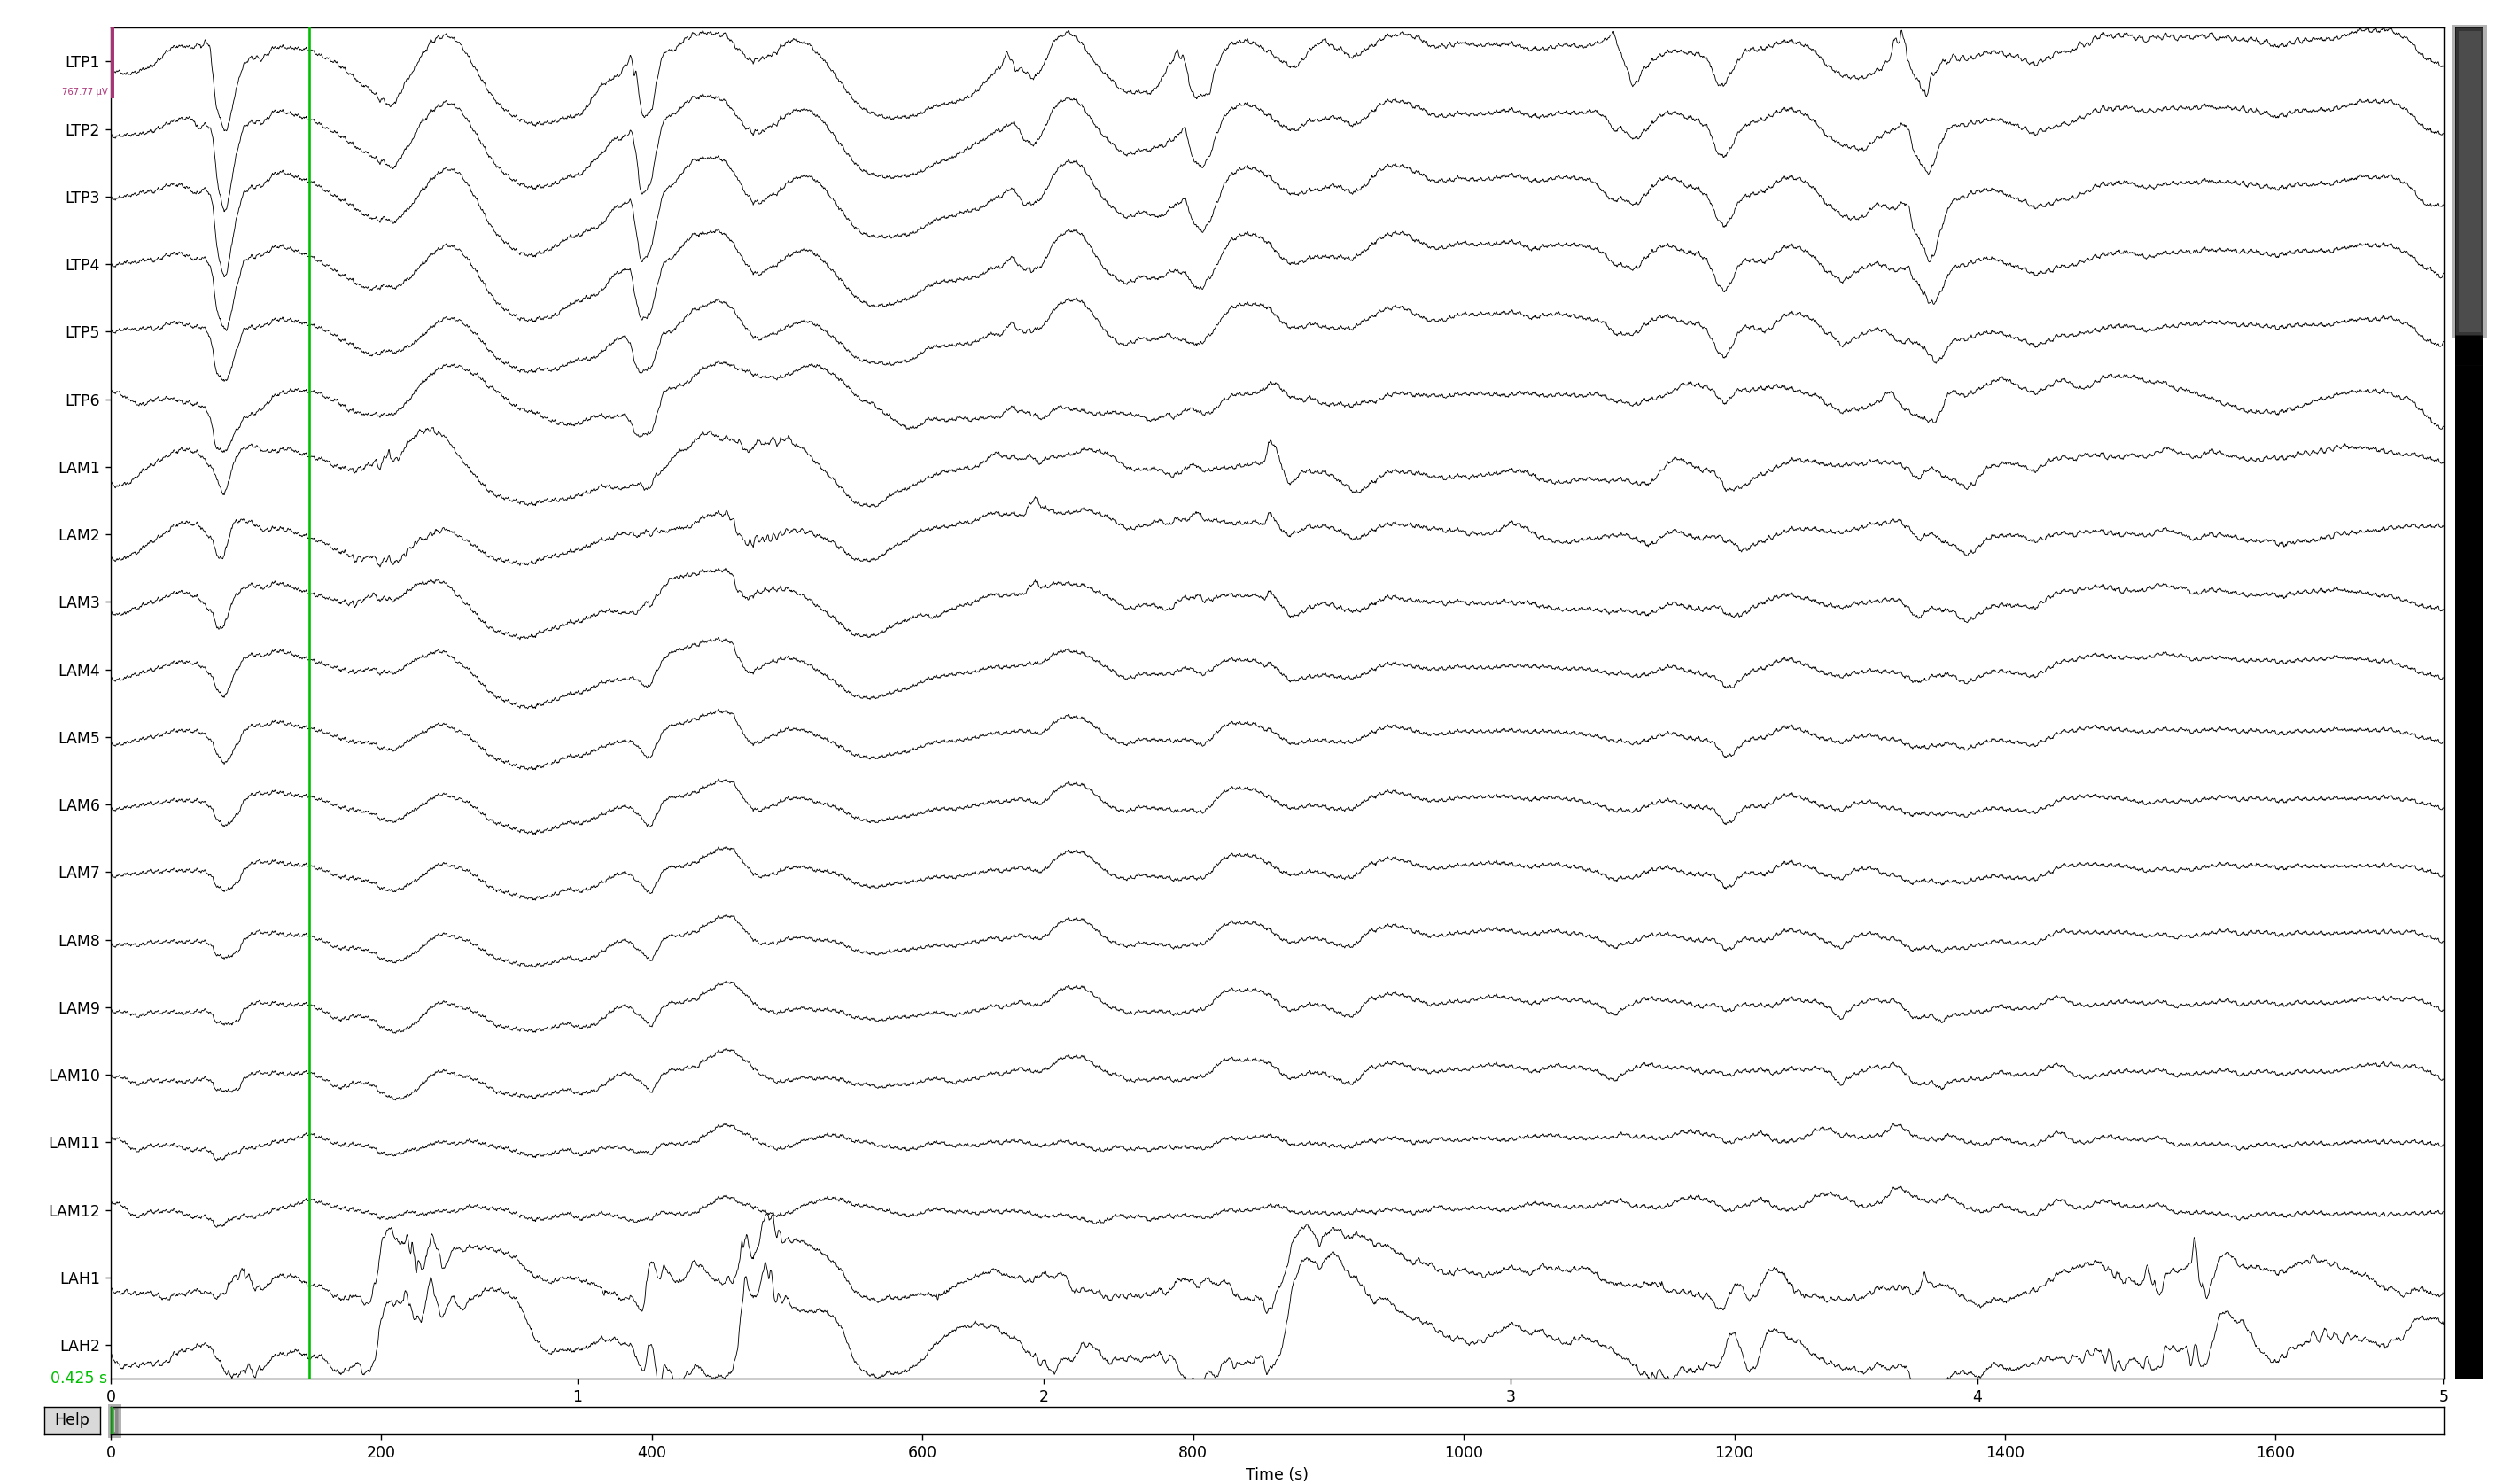

In [38]:
# DISCARD ALL CHANNELS EXCEPT GOOD SEEG CHANNELS AND THE SINGLE SCALP TARGET

channels = [i for i in raw.ch_names if i not in artifactElectrodes[patient] and i[0] in {'L', 'R'}] + [targetScalpElectrode]
raw.pick_channels(channels).plot(duration=5.0, n_channels=20);

In [7]:
# SUBSAMPLE THE DATA, MAKE MEAN=0 FOR ALL CHANNELS, AND EXTRACT TO NUMPY ARRAY

subsampleFreq = 64

df = raw.to_data_frame().drop(labels=['time'], axis=1)
data = df.to_numpy()
data = data - data.mean(axis=0, keepdims=True)
data = data[::sfreq // subsampleFreq,:]
pd.DataFrame(data, columns=df.columns)

,LTP1,LTP2,LTP3,LTP4,LTP5,LTP6,LAM1,LAM2,LAM3,LAM4,...,LOF6,LOF7,LOF8,LOF9,LOF10,LOF11,LOF12,LOF13,LOF14,F7
0,-204.914050,-145.346780,-84.154947,-170.253695,-88.899359,84.765042,-192.274041,-314.341418,-182.891634,-139.052254,...,-84.645408,-34.806876,-64.729471,-70.513765,-34.013022,-53.686079,-79.901509,-206.385571,-172.422467,55.937871
1,-218.737869,-154.385431,-91.864385,-170.253695,-89.165201,72.536279,-232.682129,-336.406360,-208.412531,-157.927084,...,-94.481587,-45.706426,-67.122055,-67.589495,-28.696169,-49.964282,-76.179712,-214.626694,-178.802692,48.228433
2,-251.968204,-146.410151,-71.660341,-150.581336,-76.138910,8.202350,-205.300333,-320.189957,-200.703094,-142.508209,...,-116.812372,-61.922829,-82.806773,-80.615786,-34.544708,-52.091023,-72.457914,-218.082649,-168.966512,29.619446
3,-225.383936,-134.713073,-47.734500,-139.947629,-65.239360,-23.698771,-148.144157,-257.982770,-134.508266,-98.910009,...,-101.393497,-47.833167,-69.248796,-60.943428,-7.428754,-16.733947,-38.695894,-192.030066,-150.091682,37.063041
4,-200.128882,-121.686782,-19.555176,-121.072799,-63.378461,-58.524162,-78.227532,-227.410862,-123.874559,-83.225291,...,-107.773721,-66.176312,-74.831493,-65.462754,-13.011451,-21.519115,-31.252299,-198.941976,-128.824268,30.416974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110371,-416.258980,-551.022709,-748.495803,-636.807597,-625.635729,-329.417853,-59.618544,158.592709,75.241608,-232.628877,...,-106.976193,19.690873,215.734556,19.075218,128.948540,155.266267,168.927239,196.631931,81.457292,46.101692
110372,-58.168891,-193.730148,-397.317623,-375.750086,-457.888998,-54.270680,-74.771577,54.116536,73.380709,-165.370679,...,-161.739785,-33.211820,173.731413,-15.484330,97.047419,120.706718,140.747915,164.996652,55.138866,50.621017
110373,110.641210,125.546910,-55.975623,-68.701791,-220.491485,175.417396,-41.009557,2.543056,129.739357,-70.464842,...,-143.928326,-24.439011,170.275458,-31.169048,62.222028,71.791665,77.477357,127.512834,-4.675737,44.506636
110374,247.550190,272.026226,147.394027,103.032580,-76.138910,234.966156,-0.867312,0.948000,174.666770,-15.169565,...,-103.520238,1.613571,170.807143,-51.373092,27.662479,-1.315072,-18.491850,97.206769,-30.462476,24.568435


In [8]:
# APPLY SHORT TERM FOURIER TRANSFORM TO THE DATA AND CHECK PARAMETERS FOR INVERTABILITY

nperseg = subsampleFreq
noverlap = nperseg - 1
window = ('tukey', .25)

f, t, S = stft(data, fs=subsampleFreq, window=window, nperseg=nperseg, noverlap=noverlap, axis=0)

print('freq, ', 'time, ', 'stft shape')
print(f.shape, t.shape, S.shape)
print('inverse ok? ',check_NOLA(window, nperseg, noverlap))

freq time stft shape
(33,) (110377,) (33, 88, 110377)
inverse ok?  True


In [9]:
# MAKE REAL-VALUED TRAINING DATA BY CONVERTING STFT COMPLEX NUMBERS TO R,THETA
# THE TARGET MUST BE THE LAST COLUMN

_,numCol,_ = S.shape
target = S[:,-1,:].transpose()
yRTheta = np.hstack([np.abs(target), np.angle(target)])
xRTheta = np.hstack([np.hstack([np.abs(S[:,i,:]).transpose(), np.angle(S[:,i,:]).transpose()]) for i in range(numCol - 1)])

yRTheta.shape, xRTheta.shape

((110377, 66), (110377, 5742))

In [21]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

<IPython.core.display.Javascript object>


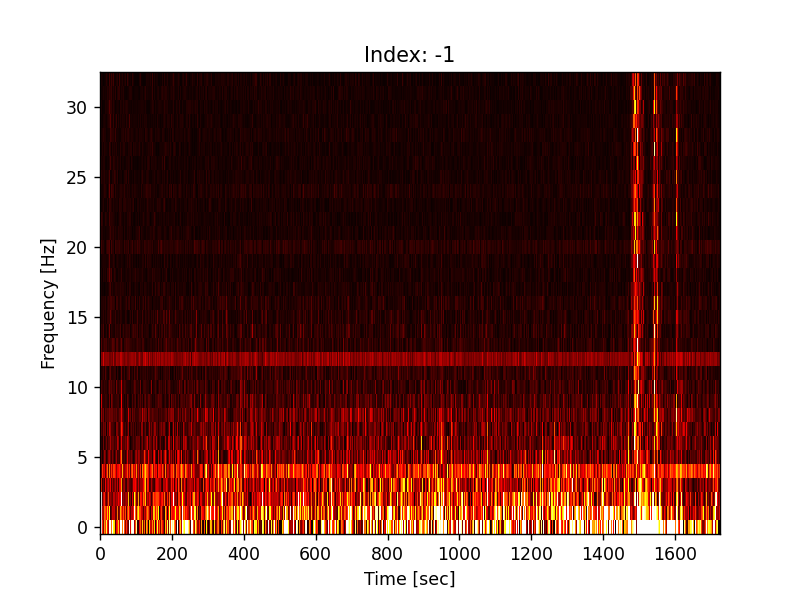

In [16]:
# PLOT THE STFT OF A TIME SERIES (MAGNITUDE ONLY)

index = -1
vmax = 20

plt.figure()
plt.pcolormesh(t, f, np.abs(S[:,index,:]), shading='auto', cmap='hot', vmin=0, vmax=vmax)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Index: %s' % str(index))
plt.show()

In [ ]:
# PARTITION INTO TRAIN AND VALIDATION SETS

dataFlag = 0

if dataFlag == 0:
    nSeconds = 1720

    lastSample = sfreq * nSeconds
    scalpData = data[0:lastSample,-1]
    seegData = data[0:lastSample,:-1]

    x_train, x_valid, y_train, y_valid = train_test_split(seegData, scalpData, test_size=0.33, random_state=42)

    train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
    valid = train.create_valid(x_valid, label=y_valid)

elif dataFlag == 1:
    # PARTITION TIME SERIES INTO CONTIGUOUS TRAIN AND VALIDATION BLOCKS

    trainSize = .66
    secondsInBlock = .6
    totalSeconds = 1720

    nBlock = totalSeconds/secondsInBlock
    samplesPerBlock = sfreq * secondsInBlock
    trainIndexProto = np.arange(0, samplesPerBlock * trainSize, dtype=int)
    validIndexProto = np.arange(samplesPerBlock * trainSize, samplesPerBlock, dtype=int)

    trainIndexBlocks = [(trainIndexProto + (i * samplesPerBlock)).astype(int) for i in range(nBlock)]
    validIndexBlocks = [(validIndexProto + (i * samplesPerBlock)).astype(int) for i in range(nBlock)]

    trainIndices = np.concatenate(trainIndexBlocks).astype(int)
    validationIndices = np.concatenate(validIndexBlocks).astype(int)

    x_train = data[trainIndices,:-1]
    y_train = data[trainIndices,-1]

    perm = np.random.permutation(x_train.shape[0])

    x_train = x_train[perm, :]
    y_train = y_train[perm]

    x_valid = data[validationIndices, :-1]
    y_valid = data[validationIndices, -1]

    train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
    valid = train.create_valid(x_valid, label=y_valid)
else:
    print("error....")

In [ ]:
# XGBOOST

 # Train a regressor on it
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=64)
reg.fit(X, y, eval_set=[(X, y)])


In [ ]:
# PLOT PREDICTION VERSUS TRUTH

times, ypred = realSTFTtoTimeSeries(reg.predict(seegData))

plt.figure()
plt.plot(ypred, label='predict')
plt.plot(scalpData, label='true')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


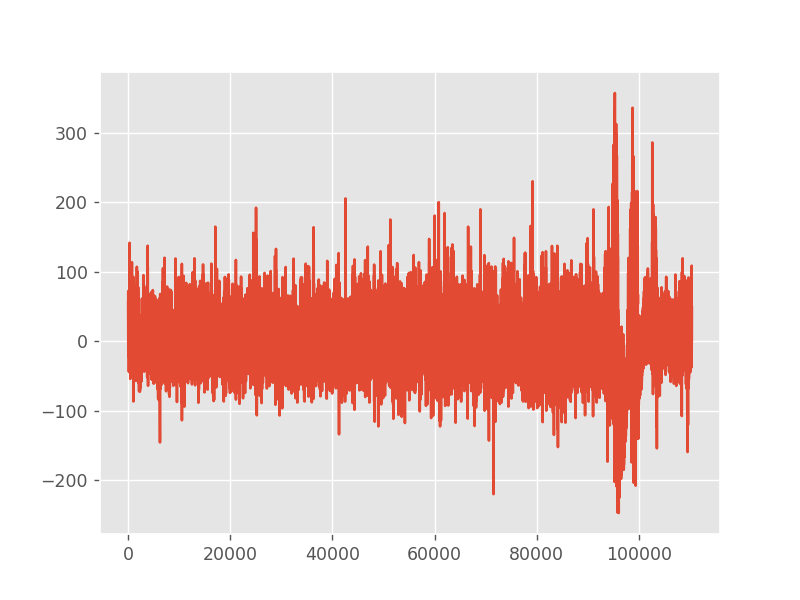

In [42]:
# PLOT THE INVERSE SHORT TERM FOURIER TRANSFORM OF A GIVEN STFT IN REAL-VALUED FORM

realSTFT = yRTheta

times, ts = realSTFTtoTimeSeries(realSTFT)
plt.figure()
plt.plot(ts)
plt.show()

# SAVE FOR LATER:

In [ ]:
# PLOT PREDICTION VERSUS TRUE FOR SECOND METHOD OF VALIDATION SET GENERATION
block = 1
x = data[validIndexBlocks[block], 0:-1]
yTrue = data[validIndexBlocks[block], -1]
ypred = bst.predict(x)

plt.figure()
plt.plot(ypred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.show()

In [ ]:
# BOKEH
from bokeh.plotting import figure, show

graph = figure(title = "Bokeh Line Graph")
graph.line(range(0,len(ypred)),ypred, line_color="red", legend_label = "prediction")
graph.line(range(0,len(ypred)),scalpData, line_color="blue", legend_label = "true")
show(graph)

In [ ]:
# PLOTLY

ypred = bst.predict(seegData)
fig = px.line(y=[ypred, scalpData])
fig.show()

In [ ]:
# LIGHTGBM

continueFlag = True
if continueFlag:
    inputModel = 'model.txt'
else:
    inputModel = None

metric = 'mse'
num_iterations = 1000
early_stopping_rounds = 5

param = {'metric': metric, 
         'num_iterations': num_iterations,
         'early_stopping_rounds': early_stopping_rounds,
         'first_metric_only': True}

bst = lgb.train(param, 
                train, 
                valid_sets=[valid, train], 
                init_model = inputModel)

print(bst.num_trees())
bst.save_model('model.txt');